# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: 6
* Students: Gabor Csordas, Maëlle Le Clainche, Nicolas Fontbonne, Marie Sadler
* Dataset: Flight routes

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [2]:
# import of routes
routes = pd.read_csv('routes.dat', sep=',', encoding='utf-8', engine='python')
routes.columns = ['Airline','Airline ID','Source Airport','Source Airport ID','Destination Airport','Destination Airport ID','Codeshare','Stops','Equipment']
routes = routes.drop(columns=['Source Airport ID','Destination Airport ID'])

# import of source and destination airport
source_airports = routes[['Source Airport']]
source_airports = source_airports.rename(columns={'Source Airport':'Airport'})

dest_airports = routes[['Destination Airport']]
dest_airports = dest_airports.rename(columns={'Destination Airport':'Airport'})

# creation of a dataframe with all airport and airport_idx 
# (we use airport_idx insteed of airportID because some airports have no airportID)
airports = pd.concat([source_airports,dest_airports])
airports = airports.drop_duplicates()
airports.reset_index(inplace=True)
airports = airports.drop(columns=['index'])
airports.reset_index(inplace=True)
airports = airports.set_index('Airport')
airports = airports.rename(columns={'index':'airport_idx'})

# reformating routes to have only airport_idx for source and destination
routes = routes.join(airports,on='Source Airport')
routes = routes.rename(columns={'airport_idx':'source_airport_idx'})
routes = routes.join(airports,on='Destination Airport')
routes = routes.rename(columns={'airport_idx':'dest_airport_idx'})

# definition of constant
n_nodes=len(airports)

### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [3]:
# Our graph has the following characteristics :
# - nodes = airports
# - links = number of flight between the two airports

n_nodes = len(airports)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx,row in routes.iterrows():
    i, j = int(row.source_airport_idx), int(row.dest_airport_idx)
    adjacency[i, j] += 1
    adjacency[j, i] += 1
    
# view of a part of adjacency
adjacency[:15, :15]

array([[ 0,  0,  4,  0,  0,  0,  2,  2,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  2,  2,  0,  0,  0,  0,  4,  0,  0],
       [ 4,  4,  0,  6,  4,  6,  8, 10,  6,  2,  4,  6,  6,  6,  2],
       [ 0,  0,  6,  0,  0,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  6,  2,  2,  0,  0,  4,  4,  0],
       [ 0,  0,  6,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  8,  2,  0,  0,  0,  6,  0,  0,  0,  0,  0,  2,  0],
       [ 2,  2, 10,  2,  6,  2,  6,  0,  2,  2,  0,  0,  6,  4,  0],
       [ 2,  0,  6,  0,  2,  0,  0,  2,  0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  2,  0,  2,  0,  0,  2,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  4,  0],
       [ 0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  4,  0],
       [ 0,  4,  6,  0,  4,  0,  0,  6,  0,  0,  6,  2,  0, 10,  0],
       [ 0,  0,  6,  0,  4,  0,  2,  4,  6,  2,  4,  4, 10,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'adjacency matrix')

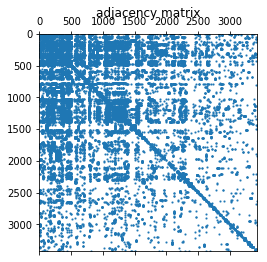

In [4]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [5]:
N = n_nodes
L_max = N*(N-1)/2
L = 1/2 * np.count_nonzero(adjacency)
print('N = ', N,'\nL_max = ', int(L_max),'\nL = ', int(L), '\nL/L_max = ', round(L/L_max, 4))

N =  3425 
L_max =  5863600 
L =  19256 
L/L_max =  0.0033


**Our network is very sparse (~0.3%) meaning the number of airports that are connected is very small compared to all possible connections between airports. This seems logical because a lot of airports are not connected to each other by direct flights.**

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**The graph of flight routes is undirected since the adjacency matrix is symmetric. In fact, we have not considered the direction of flights between airports.**

In [6]:
(np.transpose(adjacency) == adjacency).all()

True

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [7]:
routes.to_csv('flight_routes.csv', sep=',', encoding='utf-8')
np.save('adjacency',adjacency)

### Question 4

Are the edges of your graph weighted?

**It is a weighted graph where the weight of each edge represents the number of flights between two airports.**

### Question 5

What is the degree distibution of your network? 

**1. Calculation of the degree distribution on the unweighted adjacency matrix. **

In [8]:
#create an unweighted adjacency matrix
adjacency_unweighted = np.copy(adjacency)
adjacency_unweighted[adjacency_unweighted!=0]=1 #set all the non-zero elements to 1
#calculate the degree distribution
degree = np.sum(adjacency_unweighted, axis=0) 
assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

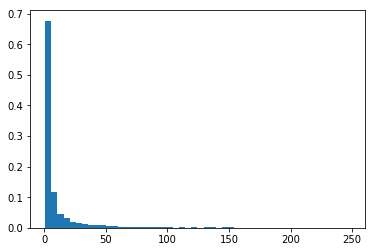

In [9]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights, bins = 50);

What is the average degree?

In [10]:
print('average degree = ', round(np.average(degree),2), '\nmedian degree = ', round(np.median(degree),2), '\nmaximum degree = ', max(degree), '\nminimum degree = ', min(degree))

average degree =  11.24 
median degree =  3.0 
maximum degree =  248 
minimum degree =  1


**2. Calculation of the strength distribution on the weighted adjacency matrix.**

In [11]:
#calculate the strength distribution
strength = np.sum(adjacency, axis=0) 

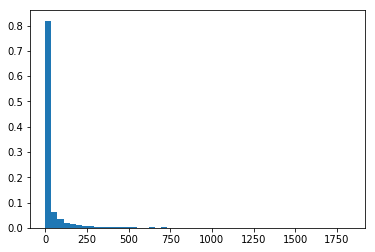

In [12]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(strength, weights=weights, bins = 50);

In [13]:
print('average strength = ', round(np.average(strength),2), '\nmedian strength = ', round(np.median(strength),2), '\nmaximum strength = ', max(strength), '\nminimum strength = ', min(strength))

average strength =  39.51 
median strength =  8.0 
maximum strength =  1826 
minimum strength =  1


### Question 6

Comment on the degree distribution of your network.

**The histogramm of the degree distribution of our network shows that half the airports have only up to 3 (median) direct airport connections, while a few ones have a very large number of connections compared with the average degree of 11.24: they are hubs, some of which have up to ~250 connections. Given that the average degree is 11.24, the network contains a lot more of "little" airports than big hubs.**

**When we look at the strength distribution we see a similar distribution with an average and median of 39.51 and 8 respectively.**

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [14]:
#recursive function that executes the BFS algorithm and labels the discovered nodes with 1  
#the vector "discovered" has the length of the number of nodes and is initialized to 0
def DFS(adjacency, discovered, node):
    discovered[node] = 1
    for i in range(0, adjacency.shape[0]):
        if (adjacency[node][i] != 0) and (discovered[i] != 1):
            DFS(adjacency, discovered, i)

In [15]:
def connected_graph(adjacency):
    """Determines whether a graph is connected."""
    
    discovered = np.zeros(adjacency.shape[0]) #initialize discovered vector
    DFS(adjacency, discovered, 0) #run the algorithm starting on node 0
    return np.sum(discovered) == adjacency.shape[0] #returns only True if all the nodes are labelled with 1

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [16]:
connected_graph(adjacency)

False

### Question 8

Write a function that extracts the connected components of a graph.

In [17]:
def find_components(adjacency):
    """Find the connected components of a graph."""
    
    components = []
    unvisited = np.arange(len(adjacency),dtype = int)
    
    
    while len(unvisited):
        source = unvisited[0]
        unvisited = np.delete(unvisited,0)
        
        component = np.array([],dtype = int)
        component = np.append(component, source)
        
        node_queue = np.array([source],dtype = int)
        while len(node_queue) != 0:
            current_node = node_queue[0]
            for node in range(len(unvisited)-1,-1,-1):
                if adjacency[current_node,unvisited[node]] != 0:
                    node_queue = np.append(node_queue,unvisited[node])
                    component =  np.append(component,unvisited[node])
                    unvisited = np.delete(unvisited,node)
            node_queue = np.delete(node_queue, 0,axis=0)
        
        component_matrix = np.zeros((len(component),len(component)),dtype = int)
        for i in range(len(component)):
            for j in range(len(component)):
                component_matrix[i,j] = adjacency[component[i],component[j]]
        components.append(component_matrix)
        
    return components


How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [18]:
components = find_components(adjacency)
n_components = len(components)
largest_component = components[0]
for component in components:
    if len(component) > len(largest_component):
        largest_component = component
print('Number of component :',n_components)
print('Size of the largest component :',len(largest_component))

Number of component : 8
Size of the largest component : 3397


In [19]:
# This is an other possibility we implemented to calculate it. It better highlights the logic but takes more stacks.

def DFS_component(adjacency, component, discovered, node):
    discovered[node] = 1
    for i in range(0, adjacency.shape[0]):
        if (adjacency[node][i] != 0):
            component[node][i] = adjacency[node][i]
            component[i][node] = adjacency[node][i]
            if discovered[i] != 1: 
                DFS_component(adjacency, component, discovered, i)
                
def find_components(adjacency):
    """Find the connected components of a graph."""
    components = []
    discovered = np.zeros(adjacency.shape[0])
    for i in range(0, adjacency.shape[0]):
        if (discovered[i] != 1):
            component = np.zeros(np.shape(adjacency))
            DFS_component(adjacency, component, discovered, i)
            components.append(component)
    return components


In [20]:
n_components = len(components)
largest_component = components[0]
for component in components:
    if len(component) > len(largest_component):
        largest_component = component
print('Number of component :',n_components)
print('Size of the largest component :',len(largest_component))

Number of component : 8
Size of the largest component : 3397


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [21]:
#to compute the shortest path between one node and the other we first initialize a vector with length 
#of the number of nodes with infinity. Thus, if two nodes are not connected their shortest path is infinity.

def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    """
    
    num_nodes = len(adjacency)
    
    
    shortest_path_lengths = np.full(num_nodes,np.inf)
    shortest_path_lengths[source] = 0
    
    unvisited = np.arange(num_nodes,dtype = int)
    unvisited = np.delete(unvisited,source)
    
    node_queue = np.array([[source,0]],dtype = int)

    while len(node_queue) != 0:
        current_node = node_queue[0][0]
        distance = node_queue[0][1]
        for node in range(len(unvisited)-1,-1,-1):
            if adjacency[current_node,unvisited[node]] != 0:
                shortest_path_lengths[unvisited[node]] = distance + 1
                node_queue = np.append(node_queue,[[unvisited[node],distance+1]],axis=0)
                unvisited = np.delete(unvisited,node)
        node_queue = np.delete(node_queue, 0,axis=0)
    
    return shortest_path_lengths

In [22]:
# Example for node 1
compute_shortest_path_lengths(adjacency, 1)

array([2., 0., 1., ..., 5., 7., 5.])

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [23]:
#we downsample our largest component to 1000 nodes by chosing the first 1000 nodes
diameter = 0
for i in range(1000):
    diameter = max(compute_shortest_path_lengths(largest_component[:1000,:1000],i).max(),diameter)
print('Diameter :',diameter)

Diameter : 5.0


### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

**We use the unweighted matrix so we get the number of geographical routes we have to visit to go from ... to ... .(If we used the weighted matrix we would obtain the number of flights we have to take to go from ... to ...)**

In [24]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node."""
# If we want to do with the weighted adjacency matric
#   n_paths=np.power(adjacency_unweighted, length)

    adjacency_matrix=np.asmatrix(adjacency) #To be sure that the power calculation will be well done we transform the array into matrix      
    n_paths=adjacency**length
    n_paths=n_paths[source,target]
    return n_paths


Test your function on 5 pairs of nodes, with different lengths.

In [25]:
# Some example to test the function
print(compute_paths(adjacency, 0, 2, 1))
print(compute_paths(adjacency, 0, 2, 4))
print(compute_paths(adjacency, 23, 24, 2))
print(compute_paths(adjacency, 23, 24, 4))
print(compute_paths(adjacency, 0, 10, 1))

4
256
36
1296
0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [26]:
n_paths = np.matrix(adjacency) ** 3
n_paths = np.sum(n_paths)
print("number of length 3 path : " + str(n_paths))

number of length 3 path : 14678892410


### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

**The function compute_clustering_coefficient is written to have in input the UNWEIGHTED adjacency matrix !**

In [27]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    """
    
    #compute the number of neighboors and a list of the non-neighboors
    nb_neighboors=0
    n_node=len(adjacency)
    list_not_neighboors=[node] #We are not interested on "node" links
    for i in range (0,n_node):
        if adjacency[i,node]!=0:
            nb_neighboors+=1;
        else:
            list_not_neighboors.append(i)

    #Delete all non neighboors in adjacency matrix
    adjacency=np.delete(adjacency,list_not_neighboors,axis=0)
    adjacency=np.delete(adjacency,list_not_neighboors,axis=1)
    
    #compute the number of links between neighboors of node
    nb_links=np.sum(adjacency)/2
    
    #compute the clustering coefficient of the node
    if (nb_neighboors>=0 and nb_neighboors<=1):
        clustering_coefficient=0;
    else :
        clustering_coefficient=2*nb_links/(nb_neighboors*(nb_neighboors-1));
    
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [28]:
#create unweighted adjacency matrix of the largest connected component 
largest_component_unweighted = largest_component.copy()
largest_component_unweighted[largest_component_unweighted!=0]=1 #set all the non-zero elements to 1
average_clustering_coefficient=0;
for node in range (0,largest_component_unweighted.shape[0]):
    average_clustering_coefficient+=compute_clustering_coefficient(largest_component_unweighted,node);
average_clustering_coefficient=average_clustering_coefficient/n_nodes;
print('Average Clustering Coefficient :',average_clustering_coefficient)

Average Clustering Coefficient : 0.4844851422603993
